# Analyze the Diversity PCA

In [2]:
import numpy as np
import os  # For Saving to Folder
import pandas as pd
import matplotlib.pyplot as plt

import socket
import os as os
import sys as sys
import multiprocessing as mp
import itertools as it
from time import time

# For Arial Font
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'   # Set the defaul
rcParams['font.sans-serif'] = ['Arial']

socket_name = socket.gethostname()
print(socket_name)

if socket_name.startswith("compute-"):
    print("HSM Computational partition detected.")
    path = "/n/groups/reich/hringbauer/git/punic_aDNA/"  # The Path on Midway Cluster
else:
    raise RuntimeWarning("Not compatible machine. Check!!")

os.chdir(path)  # Set the right Path (in line with Atom default)
# Show the current working directory. Should be HAPSBURG/Notebooks/ParallelRuns
print(os.getcwd())
print(f"CPU Count: {mp.cpu_count()}")
print(sys.version)

compute-e-16-235.o2.rc.hms.harvard.edu
HSM Computational partition detected.
/n/groups/reich/hringbauer/git/punic_aDNA
CPU Count: 28
3.7.4 (default, Sep 11 2019, 11:24:51) 
[GCC 6.2.0]


In [14]:
min_snp = 20000
path_pca = "./output/pca/v54.1var/20230417.varPCA.v54.1.construct_WE_NA_PCA.smYES.outitY.evec.txt"
path_meta = "/n/groups/reich/hringbauer/Data/v54.1.anno.csv"

savepath="" #"./output/pca/v54.1/pcs_meta.tsv"

df = pd.read_csv(path_pca, 
                 sep=r"\s+", skiprows=1, header=None)
df.columns=["iid", "pc1", "pc2", "pc3", "pc4", "pop"]
#df = remove_individuals(df, remove_list=["_d"])
df_meta = pd.read_csv(path_meta, sep=",")
df2 = df_meta[["iid", "Master ID", "loc", "n_cov_snp", 
               "mean_cov", "sex", "age", "contact", "clst", "region"]]
df = pd.merge(df, df2, on="iid", how="left")
df["clst"].fillna(inplace = True, value="missing") # Fill NaNs

idx = (df["n_cov_snp"]<min_snp)
df = df[~idx]
df.loc[df["loc"].isnull(), "loc"]="not assigned"
print(f"Filtered to {len(df)} Individuals based on Min SNP: {min_snp}")

df = df.sort_values(by="n_cov_snp", ascending=False)
dup = (df["Master ID"].duplicated() & ~df["Master ID"].isnull())
df = df[~dup].copy().reset_index(drop=True)
print(f"Filtered to {len(df)} based on duplicates")

idx = df["iid"]=="I22257" # The Sudan Outlier
df=df[~idx].copy().reset_index(drop=True)
print(f"Filtered to {len(df)} based on manual removals")
#df[df["pop"].str.contains("Lebanon")]

if len(savepath)>0:
    df.to_csv(savepath, sep="\t", index=False)
    print(f"Saved {len(df)} Indivduals with PCs to {savepath}")

Filtered to 3411 Individuals based on Min SNP: 20000
Filtered to 3411 based on duplicates
Filtered to 3411 based on manual removals


In [15]:
def plot_pca_ho(ax, df, c="gray", alpha=1.0, legend="", marker="o",
                s=30, ec=None, text=False):
    """Plot PCA onto Axis"""
    ax.scatter(-df["pc1"], df["pc2"], c=c, alpha=alpha, label=legend, 
               ec=ec, s=s, marker=marker)
    if text:
        x, y = -df["pc1"].values, df["pc2"].values
        for i, txt in enumerate(df["iid"]):
            ax.annotate(txt[:3], (x[i], y[i]), ha="center", va="center")  
            
def get_sub_pops_exact(df, pop_list=[], pop_col="pop"):
    """Get Sub Populations"""
    idx = df[pop_col].isin(pop_list)
    df = df[idx].copy()
    print(f"Found {pop_list} (exact): {len(df)}/{len(idx)}")
    return df

Found ['keep_ho'] (exact): 1132/3411


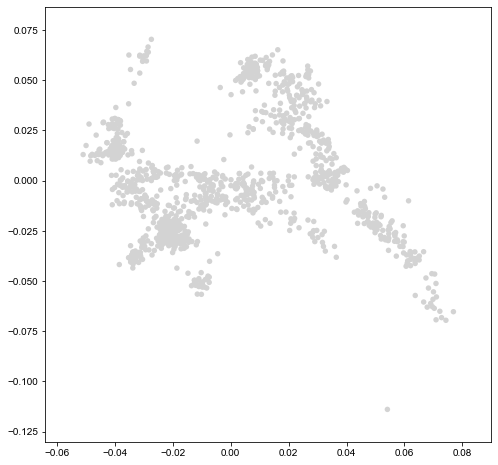

In [16]:
savepath=""
#savepath=""

df_ho = get_sub_pops_exact(df, pop_list=["keep_ho"])
plt.figure(figsize=(8,8))
ax = plt.gca()

plot_pca_ho(ax, df_ho, c="lightgray", text=False)

if len(savepath) > 0:
    plt.savefig(savepath, bbox_inches = 'tight', 
                pad_inches = 0, dpi=600)
    print(f"Saved to: {savepath}")
    
plt.show()

In [9]:
df["pop"].value_counts()

keep_anc    2279
keep_ho     1132
Name: pop, dtype: int64

# Organize samples from each site

In [19]:
df_anc = df[df["pop"]=="keep_anc"]

In [20]:
df_anc["loc"].value_counts()

Bohemia, Mikulovice                                            88
Murcia, Pliego, La Almoloya                                    66
Kamennyi Ambar 5 Cemetery                                      47
England, North Yorkshire, Vale of Pickering, West Heslerton    43
Nubia, Kulubnarti, Cemetery S                                  38
                                                               ..
Bohemia, Brandýs nad Labem                                     10
Sappali Tepe                                                   10
NW Bohemia, Teplice, Radosevice (Cemetery I)                   10
Kerkouane                                                      10
Samsun Province, İkiztepe                                      10
Name: loc, Length: 126, dtype: int64

In [74]:
def get_sub_df_region(df, region="", min_n=10):
    """Get a Dataframe of Y haplogroup diversities per sites"""
    df_reg = df[df["region"].isin(region)]
    cts = df_reg["loc"].value_counts()
    sites = cts[cts>=min_n].index.values
    
    df_res = create_pca_div_df(df, sites=sites)
    return df_res

def create_pca_div_df(df, sites=[], min_n=10):
    """Take Meta Data as input, and for each site calculates
    the Simpson Index of Y chromosomes"""
    data = []
    
    for s in sites:
        dft = df[df["loc"]==s] # Extract Site df 
        m = len(dft)
        if m==0:
            raise RuntimeWarning(f"Site {s} has no matching samples")
        
        if m >= min_n: # Calculate Variance
            vars2 = np.var(dft[["pc1", "pc2"]], axis=0)
            var = np.sum(vars2)
            age = np.median(dft["age"]) # Get the median Age
            data.append([s, age, m, var]) 
        else:
            continue
    
    # Make the summary Data Frame
    df_res = pd.DataFrame(data)
    df_res.columns = ["loc", "age", "n", "var"]
    return df_res

In [65]:
get_sub_df_region(df_anc, region=["Italy"])

,loc,age,n,var
0,"Piedmont, Collegno",1345.0,22,0.000274
1,Isola Sacra,1750.0,20,0.000445
2,"Lazio, Viterbo, Tarquinia",2151.0,17,0.000077
3,"Basilicata, Potenza, Venosa",1250.0,14,0.000201
4,Villa Magna,595.0,12,0.000150
5,"Tuscany, Grosseto, Casenovole",2350.0,10,0.000033
6,Tarquinia Monterozzi,2238.5,10,0.000629


# Do the actual Plot

In [119]:
df_y_it = get_sub_df_region(df_anc, ["Italy"], min_n=10)
df_y_fr = get_sub_df_region(df_anc, ["France", "Germany", "Austria"], min_n=10)
df_y_ib = get_sub_df_region(df_anc, ["Spain", "Portugal"], min_n=10)
df_y_lev = get_sub_df_region(df_anc, ["Israel", "Lebanon"], min_n=10)
#df_y_ib = get_sub_df_region(["Spain", "Portugal"])

df_y_pun = create_pca_div_df(df_anc, sites=["Kerkouane"], min_n=10) # "Sardinia, Tharros",  "Sicily, Selinunte, Manuzza", "Sicily, Birgi"
#df_y_him = create_pca_div_df(df_anc, sites=["Sicily, Himera"], min_n=10)

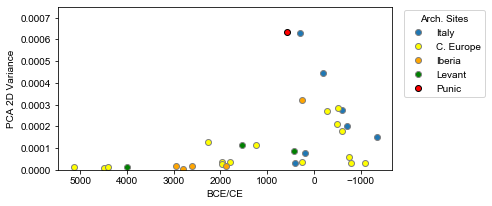

In [120]:
epsilon=0.0

plt.figure(figsize=(6,3))
ax = plt.gca()
ax.scatter(df_y_it["age"]-1950, df_y_it["var"]+epsilon, ec="gray", label="Italy")
ax.scatter(df_y_fr["age"]-1950, df_y_fr["var"]+epsilon, c="yellow", ec="gray", label="C. Europe")
ax.scatter(df_y_ib["age"]-1950, df_y_ib["var"]+epsilon, c="orange", ec="gray", label="Iberia")
ax.scatter(df_y_lev["age"]-1950, df_y_lev["var"]+epsilon, c="green", ec="gray", label="Levant")
ax.scatter(df_y_pun["age"]-1950, df_y_pun["var"]+epsilon, ec="k", c="red", label="Punic")
#ax.scatter(df_y_him["age"]-1950, df_y_him["D"]+epsilon, ec="k", c="orange", label="Himera")

ax.set_ylabel("PCA 2D Variance")
ax.set_xlabel("BCE/CE")
ax.invert_xaxis()
ax.legend(loc="upper left", title="Arch. Sites", bbox_to_anchor=(1.02, 1.01))
#ax.set_yscale('squareroot')
ax.set_ylim([0,0.00075])
plt.show()

In [122]:
df_y_it

,loc,age,n,var
0,"Piedmont, Collegno",1345.0,22,0.000274
1,Isola Sacra,1750.0,20,0.000445
2,"Lazio, Viterbo, Tarquinia",2151.0,17,0.000077
3,"Basilicata, Potenza, Venosa",1250.0,14,0.000201
4,Villa Magna,595.0,12,0.000150
5,"Tuscany, Grosseto, Casenovole",2350.0,10,0.000033
6,Tarquinia Monterozzi,2238.5,10,0.000629


# Area 51

In [123]:
df_anc[df_anc["loc"].str.contains("Tarquinia Monterozzi")]

,iid,pc1,pc2,pc3,pc4,pop,Master ID,loc,n_cov_snp,mean_cov,sex,age,contact,clst,region
121,R10361.SG,0.018501,-0.019929,0.008697,-0.002149,keep_anc,R10361,Tarquinia Monterozzi,940475.0,0.783729,M,2328.0,"Moots, Hannah M.; Pinhasi, Ron",Italy_TarquiniaMonterozzi_IA.SG,Italy
582,R10342.SG,0.026318,-0.015178,-0.001976,-0.000712,keep_anc,R10342,Tarquinia Monterozzi,786219.0,0.655183,M,2044.0,"Moots, Hannah M.; Pinhasi, Ron",Italy_TarquiniaMonterozzi_IA.SG,Italy
677,R10343.SG,0.011269,-0.013103,0.015169,-0.004025,keep_anc,R10343,Tarquinia Monterozzi,763790.0,0.636492,F,2328.0,"Moots, Hannah M.; Pinhasi, Ron",Italy_TarquiniaMonterozzi_IA.SG,Italy
698,R10363.SG,0.015554,-0.025272,0.008580,-0.001770,keep_anc,R10363,Tarquinia Monterozzi,758416.0,0.632013,M,2253.0,"Moots, Hannah M.; Pinhasi, Ron",Italy_TarquiniaMonterozzi_IA.SG,Italy
712,R10338.SG,0.014412,-0.026537,0.007785,-0.000641,keep_anc,R10338,Tarquinia Monterozzi,754348.0,0.628623,M,2328.0,"Moots, Hannah M.; Pinhasi, Ron",Italy_TarquiniaMonterozzi_IA.SG,Italy
726,R10359.SG,0.015206,-0.026961,0.013146,-0.004550,keep_anc,R10359,Tarquinia Monterozzi,751224.0,0.626020,F,2224.0,"Moots, Hannah M.; Pinhasi, Ron",Italy_TarquiniaMonterozzi_IA.SG,Italy
813,R10337.SG,-0.035047,-0.000236,0.008281,-0.000090,keep_anc,R10337,Tarquinia Monterozzi,726431.0,0.605359,M,2028.0,"Moots, Hannah M.; Pinhasi, Ron",Italy_TarquiniaMonterozzi_IA_oLevent.SG,Italy
881,R10340.SG,0.018166,-0.021824,0.007920,-0.006685,keep_anc,R10340,Tarquinia Monterozzi,709616.0,0.591347,M,2328.0,"Moots, Hannah M.; Pinhasi, Ron",Italy_TarquiniaMonterozzi_IA.SG,Italy
893,R10341.SG,-0.033897,0.007572,0.006198,-0.002651,keep_anc,R10341,Tarquinia Monterozzi,707028.0,0.589190,M,2054.0,"Moots, Hannah M.; Pinhasi, Ron",Italy_TarquiniaMonterozzi_IA_oLevent.SG,Italy
1345,R10339.SG,0.032835,-0.001707,-0.019000,-0.003498,keep_anc,R10339,Tarquinia Monterozzi,519536.0,0.432947,M,2054.0,"Moots, Hannah M.; Pinhasi, Ron",Italy_TarquiniaMonterozzi_IA.SG,Italy


In [88]:
df[df["iid"].str.contains("")]

,iid,pc1,pc2,pc3,pc4,pop,Master ID,loc,n_cov_snp,mean_cov,sex,age,contact,clst,region
0,PB675.SG,0.021355,-0.054324,0.012616,-0.000173,keep_anc,PB675,"Ireland, Clare, Parknabinnia",1150091.0,0.958409,M,5171.0,"Cassidy, Lara; Bradley, Daniel",Ireland_MN.SG,Ireland
1,SZ45.SG,0.015607,-0.011941,-0.002857,-0.005650,keep_anc,SZ45,Szólád,1149918.0,0.958265,M,1442.0,AmorimNatureCommunications2018,Hungary_Langobard_o2.SG,Hungary
2,SZ43.SG,0.006313,-0.012252,0.006175,-0.004064,keep_anc,SZ43,Szólád,1149884.0,0.958237,M,1393.0,AmorimNatureCommunications2018,Hungary_Langobard_o1.SG,Hungary
3,SZ3.SG,0.026920,-0.007115,-0.005628,0.000194,keep_anc,SZ3,Szólád,1149872.0,0.958227,M,1442.0,AmorimNatureCommunications2018,Hungary_Langobard.SG,Hungary
4,SZ4.SG,0.032431,-0.001828,-0.015421,0.000787,keep_anc,SZ4,Szólád,1149791.0,0.958159,M,1442.0,AmorimNatureCommunications2018,Hungary_Langobard.SG,Hungary
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3406,EIV004_2.HO,0.018723,-0.024538,0.010634,-0.006661,keep_ho,NaN,not assigned,NaN,NaN,NaN,NaN,NaN,missing,NaN
3407,EIV012_2.HO,0.018679,-0.031356,0.009627,0.002272,keep_ho,NaN,not assigned,NaN,NaN,NaN,NaN,NaN,missing,NaN
3408,EIV013_2.HO,0.021270,-0.025830,0.010749,-0.004161,keep_ho,NaN,not assigned,NaN,NaN,NaN,NaN,NaN,missing,NaN
3409,EIV014_2.HO,0.018666,-0.027718,0.011532,-0.003711,keep_ho,NaN,not assigned,NaN,NaN,NaN,NaN,NaN,missing,NaN
